In [98]:
import numpy as np
from functools import partial

import torch
from torch import nn
from torch.nn import functional as F

import sys
sys.path.append('../codes')

%load_ext autoreload
%autoreload 2
%aimport utils

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data
**obj_len** controls the overall length of texts. <br>Assume A is a text. If len(A) < obj_len, it will be padded. Else, it will be truncated.<br>
Change the parameters of the dataloader as you wish. 


In [100]:
data = utils.load_data(obj_len=1000,batch_size=64)

train_iter = data['train_iter']
val_iter = data['val_iter']
test_iter = data['test_iter']
embed_matrix_word2vec = data['word2vec']
embed_matrix_glove = data['glove']

In [101]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, 
                 bi_dir:bool, n_layers,
                 pretrained_embed):
        """bi_dir: Bi-directinoal if True"""
        """pretrained_embed is the embedding matrix"""
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.embedding.weight.data.copy_(pretrained_embed)
        self.embedding.weight.requires_grad = False   # freeze word embeddings
        
        self.encoder = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bi_dir)
        self.num_dir = 1 + bi_dir
        self.decoder = nn.Linear(hidden_dim * self.num_dir, output_dim)   # times 2 if the model is bi-directional
    
    def forward(self, inputs):
        # the expected input shape of RNN models are: (seq_len, batch_size, feature_dim)
        # thus we need to transpose the inputs
        embedding = self.embedding(inputs.T)  # shape: (seq_len, batch_size, embed_dim)

        self.encoder.flatten_parameters()
        _, hidden = self.encoder(embedding)  # shape: (n_layers, batch_size, hidden_dim)
        if self.encoder.bidirectional:
            outputs = torch.cat((hidden[-2],hidden[-1]),dim=1)
        else:
            outputs = hidden[-1]
        return self.decoder(outputs)

In [102]:
def init_weight(layer):
    """initialize the weight of a layer"""
    """Use Xavier initialization"""
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)
    if type(layer) == nn.GRU:
        for param_name in layer._flat_weights_names:
            if "weight" in param_name:
                nn.init.xavier_uniform_(layer._parameters[param_name])

In [103]:
fixed_params = {
    "vocab_size":embed_matrix_glove.shape[0],
    "embed_dim":embed_matrix_glove.shape[1],
    "output_dim":4
}

gru = partial(GRUModel, **fixed_params)

# Glove

In [105]:
glove_params = {
    "hidden_dim":64,
    "bi_dir":False,
    "n_layers":1,
    "pretrained_embed":embed_matrix_glove
}

gru_glove = gru(**glove_params)
gru_glove.apply(init_weight)    # Xavier intialization

GRUModel(
  (embedding): Embedding(25002, 300)
  (encoder): GRU(300, 64)
  (decoder): Linear(in_features=64, out_features=4, bias=True)
)

set **verbose** == True if you wanna monitor the training process.

CUDA is available. Training on GPU.


  5%|▌         | 1/20 [00:06<02:09,  6.83s/it]

epoch 0   train_f1: 0.406, val_f1: 0.405



 10%|█         | 2/20 [00:13<01:59,  6.64s/it]

epoch 1   train_f1: 0.949, val_f1: 0.942



 15%|█▌        | 3/20 [00:19<01:51,  6.56s/it]

epoch 2   train_f1: 0.975, val_f1: 0.964



 20%|██        | 4/20 [00:26<01:45,  6.58s/it]

epoch 3   train_f1: 0.986, val_f1: 0.972



 25%|██▌       | 5/20 [00:32<01:38,  6.56s/it]

epoch 4   train_f1: 0.989, val_f1: 0.973



 30%|███       | 6/20 [00:39<01:31,  6.55s/it]

epoch 5   train_f1: 0.994, val_f1: 0.976



 35%|███▌      | 7/20 [00:46<01:25,  6.61s/it]

epoch 6   train_f1: 0.994, val_f1: 0.976



 40%|████      | 8/20 [00:52<01:19,  6.61s/it]

epoch 7   train_f1: 0.997, val_f1: 0.975



 45%|████▌     | 9/20 [00:59<01:13,  6.66s/it]

epoch 8   train_f1: 0.990, val_f1: 0.969



 50%|█████     | 10/20 [01:06<01:06,  6.65s/it]

epoch 9   train_f1: 0.997, val_f1: 0.977



 55%|█████▌    | 11/20 [01:12<00:59,  6.66s/it]

epoch 10   train_f1: 0.999, val_f1: 0.978



 60%|██████    | 12/20 [01:19<00:53,  6.67s/it]

epoch 11   train_f1: 0.999, val_f1: 0.977



 65%|██████▌   | 13/20 [01:26<00:46,  6.68s/it]

epoch 12   train_f1: 0.998, val_f1: 0.977



 70%|███████   | 14/20 [01:33<00:40,  6.76s/it]

epoch 13   train_f1: 0.999, val_f1: 0.977



 75%|███████▌  | 15/20 [01:39<00:33,  6.75s/it]

epoch 14   train_f1: 1.000, val_f1: 0.977



 80%|████████  | 16/20 [01:46<00:26,  6.72s/it]

epoch 15   train_f1: 1.000, val_f1: 0.979



 85%|████████▌ | 17/20 [01:53<00:20,  6.71s/it]

epoch 16   train_f1: 0.999, val_f1: 0.976



 90%|█████████ | 18/20 [02:00<00:13,  6.72s/it]

epoch 17   train_f1: 0.999, val_f1: 0.976



 95%|█████████▌| 19/20 [02:06<00:06,  6.71s/it]

epoch 18   train_f1: 1.000, val_f1: 0.978



100%|██████████| 20/20 [02:13<00:00,  6.66s/it]

epoch 19   train_f1: 0.999, val_f1: 0.978



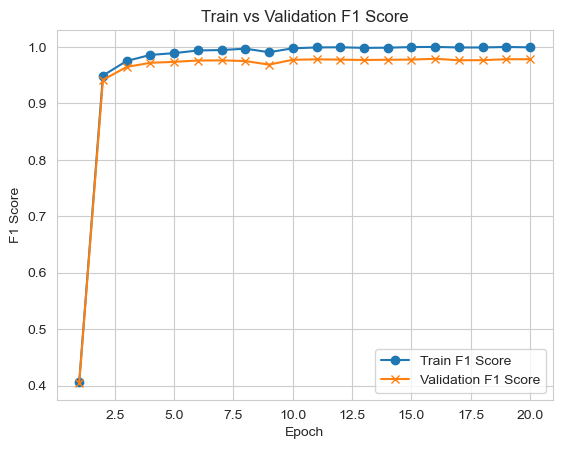

In [106]:
utils.train(gru_glove, train_iter, val_iter, 
            lr=1e-3, num_epochs=20, verbose=True)

In [107]:
utils.calculate_metric(gru_glove, test_iter, device="cuda")

0.5745332232817442

It's strange that the model performs very well on the validation set but performs poorly on the test set. I made sure that there's no data leakage except the vocabulary is derived on the union of training and validation set. The distribution of test data might be different from the training corpus.

In [109]:
# confusion matrix
utils.get_cm(gru_glove, test_iter, device="cuda")

array([[0.75, 0.16, 0.04, 0.05],
       [0.03, 0.56, 0.4 , 0.01],
       [0.07, 0.  , 0.14, 0.78],
       [0.04, 0.  , 0.02, 0.94]])

The model's terrible at predicting class 2 and 3

# Word2vec

In [110]:
word2vec_params = {
    "hidden_dim":64,
    "bi_dir":False,
    "n_layers":1,
    "pretrained_embed":embed_matrix_word2vec
}

gru_word2vec = gru(**word2vec_params)
gru_word2vec.apply(init_weight)     # Xavier intialization

GRUModel(
  (embedding): Embedding(25002, 300)
  (encoder): GRU(300, 64)
  (decoder): Linear(in_features=64, out_features=4, bias=True)
)

CUDA is available. Training on GPU.


100%|██████████| 25/25 [02:45<00:00,  6.64s/it]


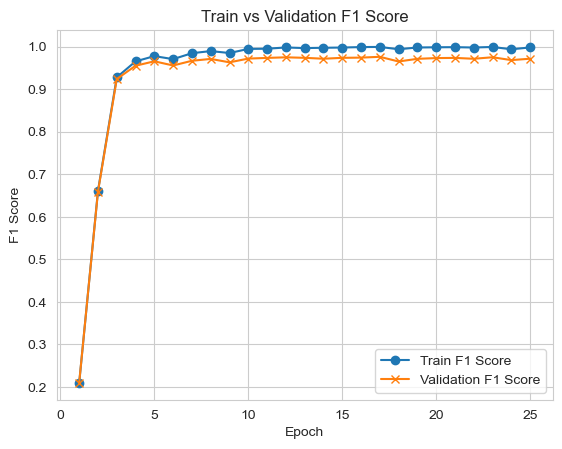

In [111]:
utils.train(gru_word2vec, train_iter, val_iter, 
            lr=1e-3, num_epochs=25, verbose=False)

In [77]:
utils.calculate_metric(gru_word2vec, test_iter, device="cuda")

0.4680847386662652